In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
import cyrtranslit
from sklearn import preprocessing, model_selection, metrics, feature_selection, ensemble, linear_model, cross_decomposition, feature_extraction, decomposition
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import time
color = sns.color_palette()

%matplotlib inline

In [2]:
train = pd.read_pickle('../../train.pkl',compression='zip')

test = pd.read_pickle('../../test.pkl',compression='zip')

In [3]:
ru_stop = nltk.corpus.stopwords.words('russian')

# PLSSVD

- Before repeating the newest methods on the descriptions, it's worth comparing PLSR with another algorithm for cross-decomposition.
- SVD (Single Value Decomposition) is popular as an unsupervised technique for grouping term-frequency matrices into similar topics. Since we have a supervised goal here and we want to reduce many correlated features, PLSSVD sounds like an ideal option for predictive NLP.

In [4]:
vec = feature_extraction.text.TfidfVectorizer(
    stop_words=ru_stop,
    lowercase=False,
    #max_features=8600,
    #ngram_range=(2,2),
    min_df=0.000005,
    #max_df=0.0005
)
# Fitting on train and test as merged lists
vec.fit(train['title'].values.tolist() + test['title'].values.tolist())
print(len(vec.get_feature_names()))

34568


- Used same vectorizer settings as last with no ngrams.
- Now transform train titles.

In [5]:
# Word counts for train titles. CSR Matrix, tokens ordered alphabetically
counts = vec.transform(train['title'].values.tolist())

**Getting Familiar with PLSSVD**

- It can only reduce to 1 component, regardless of the chosen `n_components`. See below for demonstration.

In [7]:
index = np.random.choice(len(train),size=int(1e5))

In [8]:
X = counts[index,0:7000].toarray()
y = train.iloc[index].deal_probability.values
print(X.shape,y.shape)

(100000, 7000) (100000,)


In [9]:
reducer = cross_decomposition.PLSSVD()
reducer.fit(X,y)

PLSSVD(copy=True, n_components=2, scale=True)

In [10]:
X_reduced = reducer.transform(X)

In [11]:
print(X_reduced.shape)

(100000, 1)


- I'll adjust to this limitation of being forced to one component per reduction. Just some few modifications and the code below can give PLSSVD a shot.

In [13]:
# Reduce all CSR values in batches
t = time.time()
reduced = pd.DataFrame(index=train.index)
low_col = 0
# Start iteration with columns
for col in np.arange(0,int(counts.shape[1]*1.05),2000):
    # Limiting the edge case of the last values
    if col > counts.shape[1]:
        col = counts.shape[1]
    up_col = col
    
    if up_col > low_col:
        # Train PLSR on a large sample of those columns from CSR
        index = np.random.choice(len(train),size=int(4e5))
        sample = counts[index,low_col:up_col].toarray()
        reduce = cross_decomposition.PLSSVD()
        reduce.fit(sample,train.iloc[index].deal_probability)
        
        # Nested indexes iteration
        components = pd.DataFrame()
        low_idx = 0
        for idx in np.arange(0,int(len(train)*1.1),int(3.1e5)):
            # Limiting the edge case of the last values
            if idx > len(train):
                idx = len(train)
            up_idx = idx

            if up_idx > low_idx:
                sample = counts[low_idx:up_idx,low_col:up_col].toarray()
                sample = reduce.transform(sample)
                components = components.append(pd.DataFrame(sample))
                low_idx = idx
        components.reset_index(drop=True,inplace=True)
        components.columns = ['col_{}-{}'.format(low_col,up_col)]
        reduced = reduced.join(components)
        print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))
        print('Aggregate shape:',reduced.shape,'\n')
        low_col = col
print('Minutes:',(time.time()-t)/60)

Aggregate score: [0.01927252 0.01750745 0.01717554 0.01912741]
Aggregate shape: (1503424, 1) 

Aggregate score: [0.02275625 0.02090275 0.02033845 0.02261389]
Aggregate shape: (1503424, 2) 

Aggregate score: [0.02732133 0.02515156 0.02497476 0.02763026]
Aggregate shape: (1503424, 3) 

Aggregate score: [0.03080157 0.02809287 0.02839658 0.03019428]
Aggregate shape: (1503424, 4) 

Aggregate score: [0.03416668 0.03161745 0.03217493 0.03318585]
Aggregate shape: (1503424, 5) 

Aggregate score: [0.04726586 0.04513701 0.0461211  0.04621349]
Aggregate shape: (1503424, 6) 

Aggregate score: [0.06468119 0.06202052 0.06444651 0.06483555]
Aggregate shape: (1503424, 7) 

Aggregate score: [0.08604026 0.08200954 0.08549695 0.0853375 ]
Aggregate shape: (1503424, 8) 

Aggregate score: [0.10927583 0.10439943 0.10828124 0.10825771]
Aggregate shape: (1503424, 9) 

Aggregate score: [0.13181339 0.12596702 0.13128313 0.13113565]
Aggregate shape: (1503424, 10) 

Aggregate score: [0.14240346 0.13605017 0.1412671

In [16]:
reduced.shape

(1503424, 18)

- Further reduce to 10 components.

In [17]:
reduce = cross_decomposition.PLSRegression(n_components=10)
reduce.fit(reduced,train.deal_probability)
print('Score for feature range:',reduce.score(reduced,train.deal_probability))

Score for feature range: 0.16886445892078206


In [18]:
reduced2 = reduce.transform(reduced)

In [19]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced2,y=train.deal_probability))

Aggregate score: [0.17118265 0.16510414 0.16942562 0.16957116]


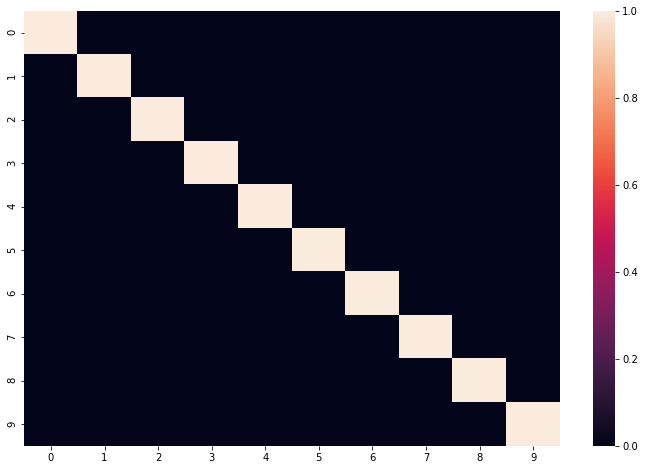

In [20]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(reduced2).corr())
plt.show()

**Conclusion**

- It's not a decrease, but neither an improvement from standard PLSR.